# Statistics for Ensemble Method

## Bootstrapping

In [1]:
from random import choice
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
boston = pd.read_csv("BostonHousing.csv")

#### Meaning of columns

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per 10,000 dollar
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in 1000 dollar's

In [3]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Resample

In [4]:
from sklearn.utils import resample

In [5]:
boston.shape

(506, 14)

In [6]:
rad = boston["rad"].values

(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

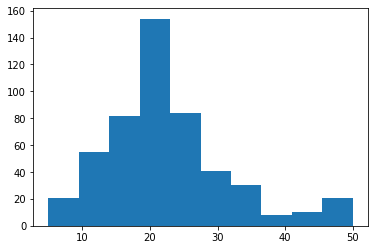

In [7]:
plt.hist(boston["medv"])

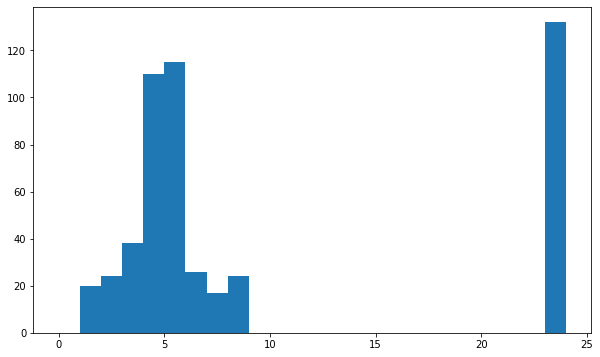

In [8]:
plt.figure(figsize=(10,6))
plt.hist(rad,bins=[i for i in range(25)]);

In [9]:
rad_train = resample(rad,n_samples=50,random_state=0)

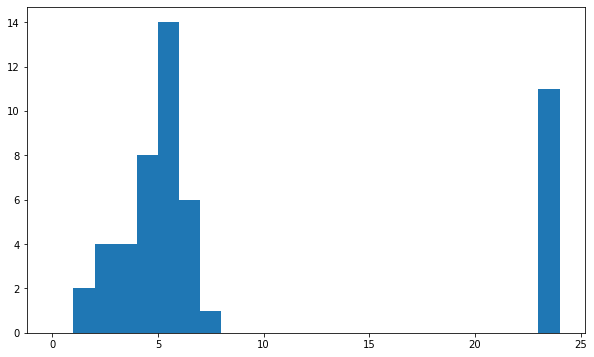

In [10]:
plt.figure(figsize=(10,6))
plt.hist(rad_train,bins=[i for i in range(25)],color="C0");

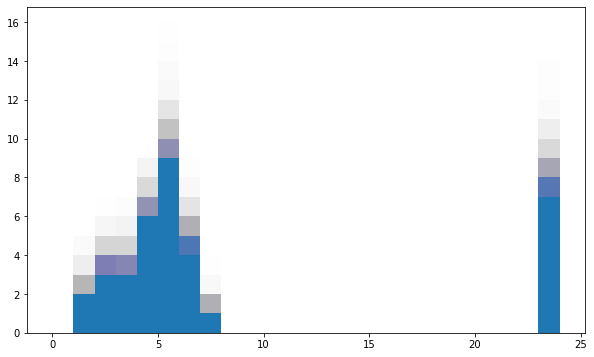

In [11]:
plt.figure(figsize=(10,6))
for i in range(1000):
    bootstrapped = resample(rad_train,n_samples=25,random_state=i)
    plt.hist(bootstrapped,bins=[i for i in range(25)],alpha=0.005,color="C0")

### Preprocessing and train/test splitting

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
boston_bag = boston.copy()
boston_bag["medv"] = boston_bag["medv"].apply(lambda x: int(x>= np.median(boston_bag["medv"])))
boston_bag_train, boston_bag_test = train_test_split(boston_bag,train_size=0.7,shuffle=True,random_state=1)
boston_bag_train_X, boston_bag_train_y = boston_bag_train.drop(["medv"],axis=1).to_numpy(),  boston_bag_train["medv"].to_numpy()
boston_bag_test_X, boston_bag_test_y = boston_bag_test.drop(["medv"],axis=1).to_numpy(),  boston_bag_test["medv"].to_numpy()

### Reproduce the Bias-Variance Tradeoff on a single decision tree

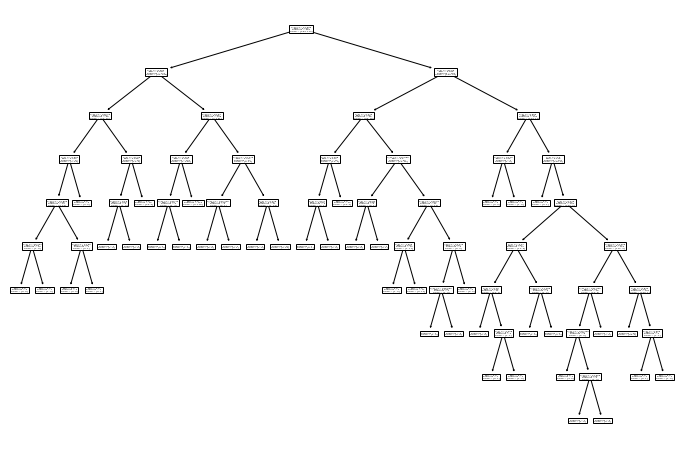

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0)
clf.fit(boston_bag_train_X, boston_bag_train_y)
plt.figure(figsize=(12,8))
tree.plot_tree(clf);

In [14]:
f1_score(boston_bag_train_y,clf.predict(boston_bag_train_X))

1.0

In [15]:
train_f1 = []
test_f1 = []
depths = range(1,11)
for depth in depths:
    clf = DecisionTreeClassifier(random_state=0,max_depth=depth)
    clf.fit(boston_bag_train_X, boston_bag_train_y)
    train_f1.append(f1_score(boston_bag_train_y,clf.predict(boston_bag_train_X)))
    test_f1.append(f1_score(boston_bag_test_y,clf.predict(boston_bag_test_X)))

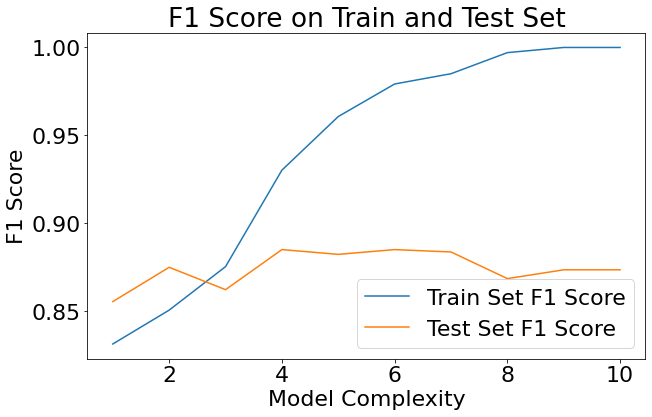

In [16]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 22})
plt.plot(depths,train_f1,label="Train Set F1 Score")
plt.plot(depths,test_f1, label="Test Set F1 Score")
plt.legend()
plt.xlabel("Model Complexity")
plt.ylabel("F1 Score")
plt.title("F1 Score on Train and Test Set");

### Bagging Classifier

In [17]:
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(random_state = 0, max_depth = 4)
bagging_clf = BaggingClassifier(base_estimator=base_estimator, 
                                n_estimators=10,
                                n_jobs=20, 
                                max_samples=0.7,
                                random_state=0,)

bagging_clf.fit(boston_bag_train_X, boston_bag_train_y);

In [18]:
f1_score(boston_bag_train_y, bagging_clf.predict(boston_bag_train_X))

0.9464285714285714

In [19]:
f1_score(boston_bag_test_y, bagging_clf.predict(boston_bag_test_X))

0.874251497005988

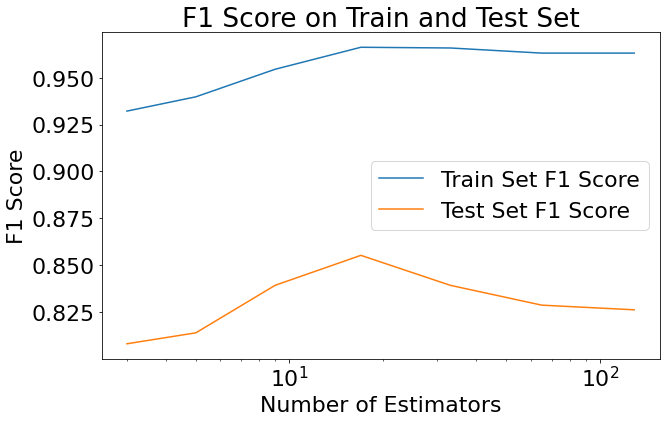

In [20]:
boston_bag_train, boston_bag_test = train_test_split(boston_bag,train_size=0.7,shuffle=True,random_state=0)
boston_bag_train_X, boston_bag_train_y = boston_bag_train.drop(["medv"],axis=1).to_numpy(),  boston_bag_train["medv"].to_numpy()
boston_bag_test_X, boston_bag_test_y = boston_bag_test.drop(["medv"],axis=1).to_numpy(),  boston_bag_test["medv"].to_numpy()
train_f1 = []
test_f1 = []
n_estimators = [2**i+1 for i in range(1,8)]
for n_estimator in n_estimators:
    bagging_clf = BaggingClassifier(base_estimator=base_estimator, 
                                    n_estimators=n_estimator,
                                    n_jobs=20, 
                                    random_state=0,)
    bagging_clf.fit(boston_bag_train_X, boston_bag_train_y);
    train_f1.append(f1_score(boston_bag_train_y, bagging_clf.predict(boston_bag_train_X)))
    test_f1.append(f1_score(boston_bag_test_y, bagging_clf.predict(boston_bag_test_X)))
plt.figure(figsize=(10,6))
plt.plot(n_estimators,train_f1,label="Train Set F1 Score")
plt.plot(n_estimators,test_f1, label="Test Set F1 Score")
plt.xscale("log")
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("F1 Score")
plt.title("F1 Score on Train and Test Set");

### Changing training dataset and impose further regularization

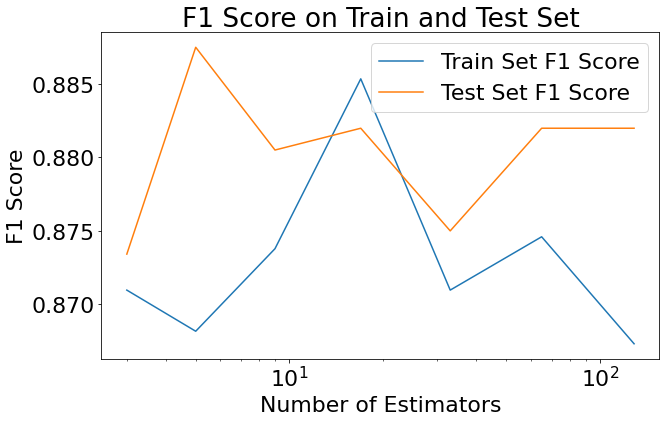

In [21]:
boston_bag_train, boston_bag_test = train_test_split(boston_bag,train_size=0.7,shuffle=True,random_state=1)
boston_bag_train_X, boston_bag_train_y = boston_bag_train.drop(["medv"],axis=1).to_numpy(),  boston_bag_train["medv"].to_numpy()
boston_bag_test_X, boston_bag_test_y = boston_bag_test.drop(["medv"],axis=1).to_numpy(),  boston_bag_test["medv"].to_numpy()
train_f1 = []
test_f1 = []
n_estimators = [2**i+1 for i in range(1,8)]
base_estimator = DecisionTreeClassifier(random_state = 0, max_depth = 4,min_samples_split=30)
for n_estimator in n_estimators:
    bagging_clf = BaggingClassifier(base_estimator=base_estimator, 
                                    n_estimators=n_estimator,
                                    n_jobs=20, 
                                    random_state=0,)
    bagging_clf.fit(boston_bag_train_X, boston_bag_train_y);
    train_f1.append(f1_score(boston_bag_train_y, bagging_clf.predict(boston_bag_train_X)))
    test_f1.append(f1_score(boston_bag_test_y, bagging_clf.predict(boston_bag_test_X)))
plt.figure(figsize=(10,6))
plt.plot(n_estimators,train_f1,label="Train Set F1 Score")
plt.plot(n_estimators,test_f1, label="Test Set F1 Score")
plt.xscale("log")
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("F1 Score")
plt.title("F1 Score on Train and Test Set");

## Boosting
### Gradient Descent Boosting

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

boston_boost = boston.copy()
boston_boost_train, boston_boost_test = train_test_split(boston_boost,
                                                     train_size=0.7,
                                                     shuffle=True,
                                                     random_state=1)
boston_boost_train_X, boston_boost_train_y = boston_boost_train.drop(["medv"],axis=1).to_numpy(), boston_boost_train["medv"].to_numpy()
boston_boost_test_X, boston_boost_test_y = boston_boost_test.drop(["medv"],axis=1).to_numpy(), boston_boost_test["medv"].to_numpy()
gdb_reg = GradientBoostingRegressor(random_state=0)

gdb_reg.fit(boston_boost_train_X, boston_boost_train_y);

print(mean_squared_error(gdb_reg.predict(boston_boost_train_X), boston_boost_train_y))

1.4717545900850844


In [23]:
mean_squared_error(gdb_reg.predict(boston_boost_test_X), boston_boost_test_y)

7.220741970204592

#### Number of estimators/iterations

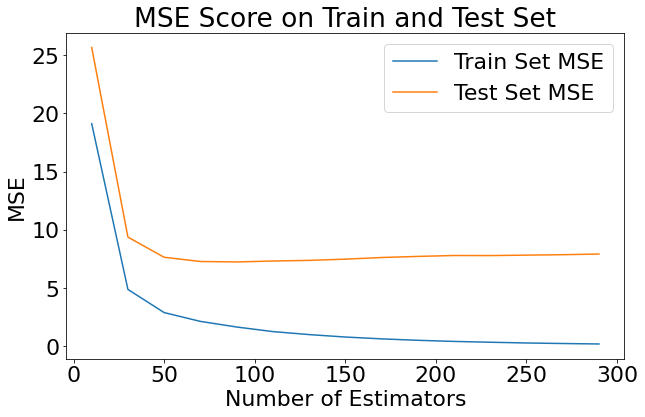

In [24]:
train_mse = []
test_mse = []
n_estimators = range(10,300,20)
for n_estimator in n_estimators:
    gdb_reg = GradientBoostingRegressor(random_state=0,n_estimators=n_estimator)
    gdb_reg.fit(boston_boost_train_X, boston_boost_train_y);
    train_mse.append(mean_squared_error(gdb_reg.predict(boston_boost_train_X), boston_boost_train_y))
    test_mse.append(mean_squared_error(gdb_reg.predict(boston_boost_test_X), boston_boost_test_y))
plt.figure(figsize=(10,6))
plt.plot(n_estimators,train_mse,label="Train Set MSE")
plt.plot(n_estimators,test_mse, label="Test Set MSE")
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("MSE")
plt.title("MSE Score on Train and Test Set");

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
regr = RandomForestRegressor(max_depth=5, 
                             random_state=0,
                             n_estimators=25,
                            max_features="sqrt")
regr.fit(boston_boost_train_X, boston_boost_train_y);

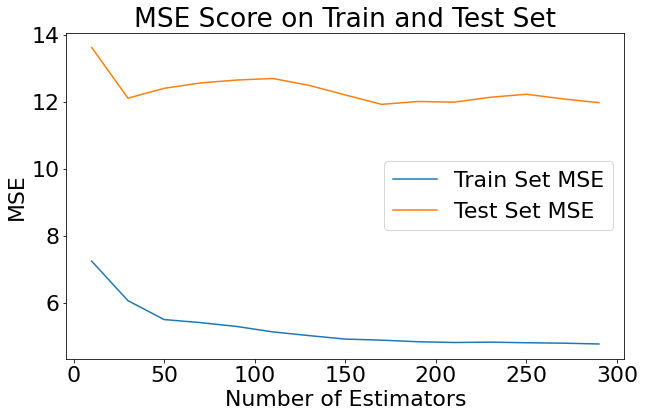

In [27]:
train_mse = []
test_mse = []
n_estimators = range(10,300,20)
for n_estimator in n_estimators:
    regr = RandomForestRegressor(max_depth=6, 
                             random_state=0,
                             n_estimators=n_estimator,
                            max_features="sqrt")
    regr.fit(boston_boost_train_X, boston_boost_train_y);
    train_mse.append(mean_squared_error(regr.predict(boston_boost_train_X), boston_boost_train_y))
    test_mse.append(mean_squared_error(regr.predict(boston_boost_test_X), boston_boost_test_y))
plt.figure(figsize=(10,6))
plt.plot(n_estimators,train_mse,label="Train Set MSE")
plt.plot(n_estimators,test_mse, label="Test Set MSE")
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("MSE")
plt.title("MSE Score on Train and Test Set");